# Welcome to Passion!
Passion is a model that can detection anomaly using different methods (Both supervised and unsupervised) <br>

1. The goal for this project is to study the difference between different anomnaly detection model, and to   <br>
 find the state of art method for detecting anomaly in real world data<br>
2. Evaluate the results based on this : https://github.com/numenta/NAB <br>
3. Also use real data generated from server.
4. The model has the following fuctions: <br>
    a. Visualize the input data. Help the user to find critical features within the inputs. <br>
    b. Give user options to choose different models that are suitable for different circumstances. <br>
    c. Evaluate the performance based on the rules in this link https://github.com/numenta/NAB <br>
    d. Save model. Easy to be appplied to other dataset. <br>

5. This is the very beginning of the process. Still need to do a lot of works!



# What's new in version 3
1. Remove HTM model <br>
2. Add DeepAR
3. Add Transformer
4. Add HMM
5. Add prophet
6. Use real server data

In [1]:
# import packages 


from matplotlib.pylab import rc
import torch
from scipy.stats import chisquare
from scipy.stats import pearsonr 
import pickle
import pandas as pd
import datetime
import matplotlib
import tensorflow as tf
import sklearn
import math
import matplotlib.pyplot as plt
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
import numpy as np
from sklearn.model_selection import train_test_split 
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder 
import copy
import scipy
import datetime
import time
import os
from sklearn.model_selection import KFold 
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from hmmlearn import hmm



In [2]:
# plot path:
plot_path = "plots/"

# AWS data
aws = pd.read_csv("Data/realKnownCause/realKnownCause/"+'ambient_temperature_system_failure.csv')


In [15]:
# Real server data

root_path = "Data/Ant_202007/"


cif = pd.read_json(root_path+'cif.json', orient='index')
paycore = pd.read_json(root_path+'paycore.json', orient='index')
paydecision = pd.read_json(root_path+'paydecision.json', orient='index')
paydecision2 = pd.read_json(root_path+'paydecision2.json', orient='index')
paydecision3 = pd.read_json(root_path+'paydecision3.json', orient='index')

df = pd.DataFrame()
df["time_stamp"] = cif.index
df["cif"] = cif[0].values
df["paycore"] = paycore[0].values
df["paydecision"] = paydecision[0].values
df["paydecision2"] = paydecision2[0].values
df["paydecision3"] = paydecision3[0].values

# Optional
if False:
    df.to_csv(root_path+"fusion.csv")

os.listdir(root_path)



['cif.json',
 'fusion.csv',
 'paycore.json',
 'paydecision.json',
 'paydecision2.json',
 'paydecision3.json']

In [26]:

# convert time stamp
df['time_stamp'] = pd.to_datetime(df['time_stamp'])
names_array = np.array(df.keys()[1:],dtype="str")

W0707 17:33:45.310931 140651344062272 font_manager.py:1269] findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
W0707 17:33:45.386096 140651344062272 font_manager.py:1269] findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


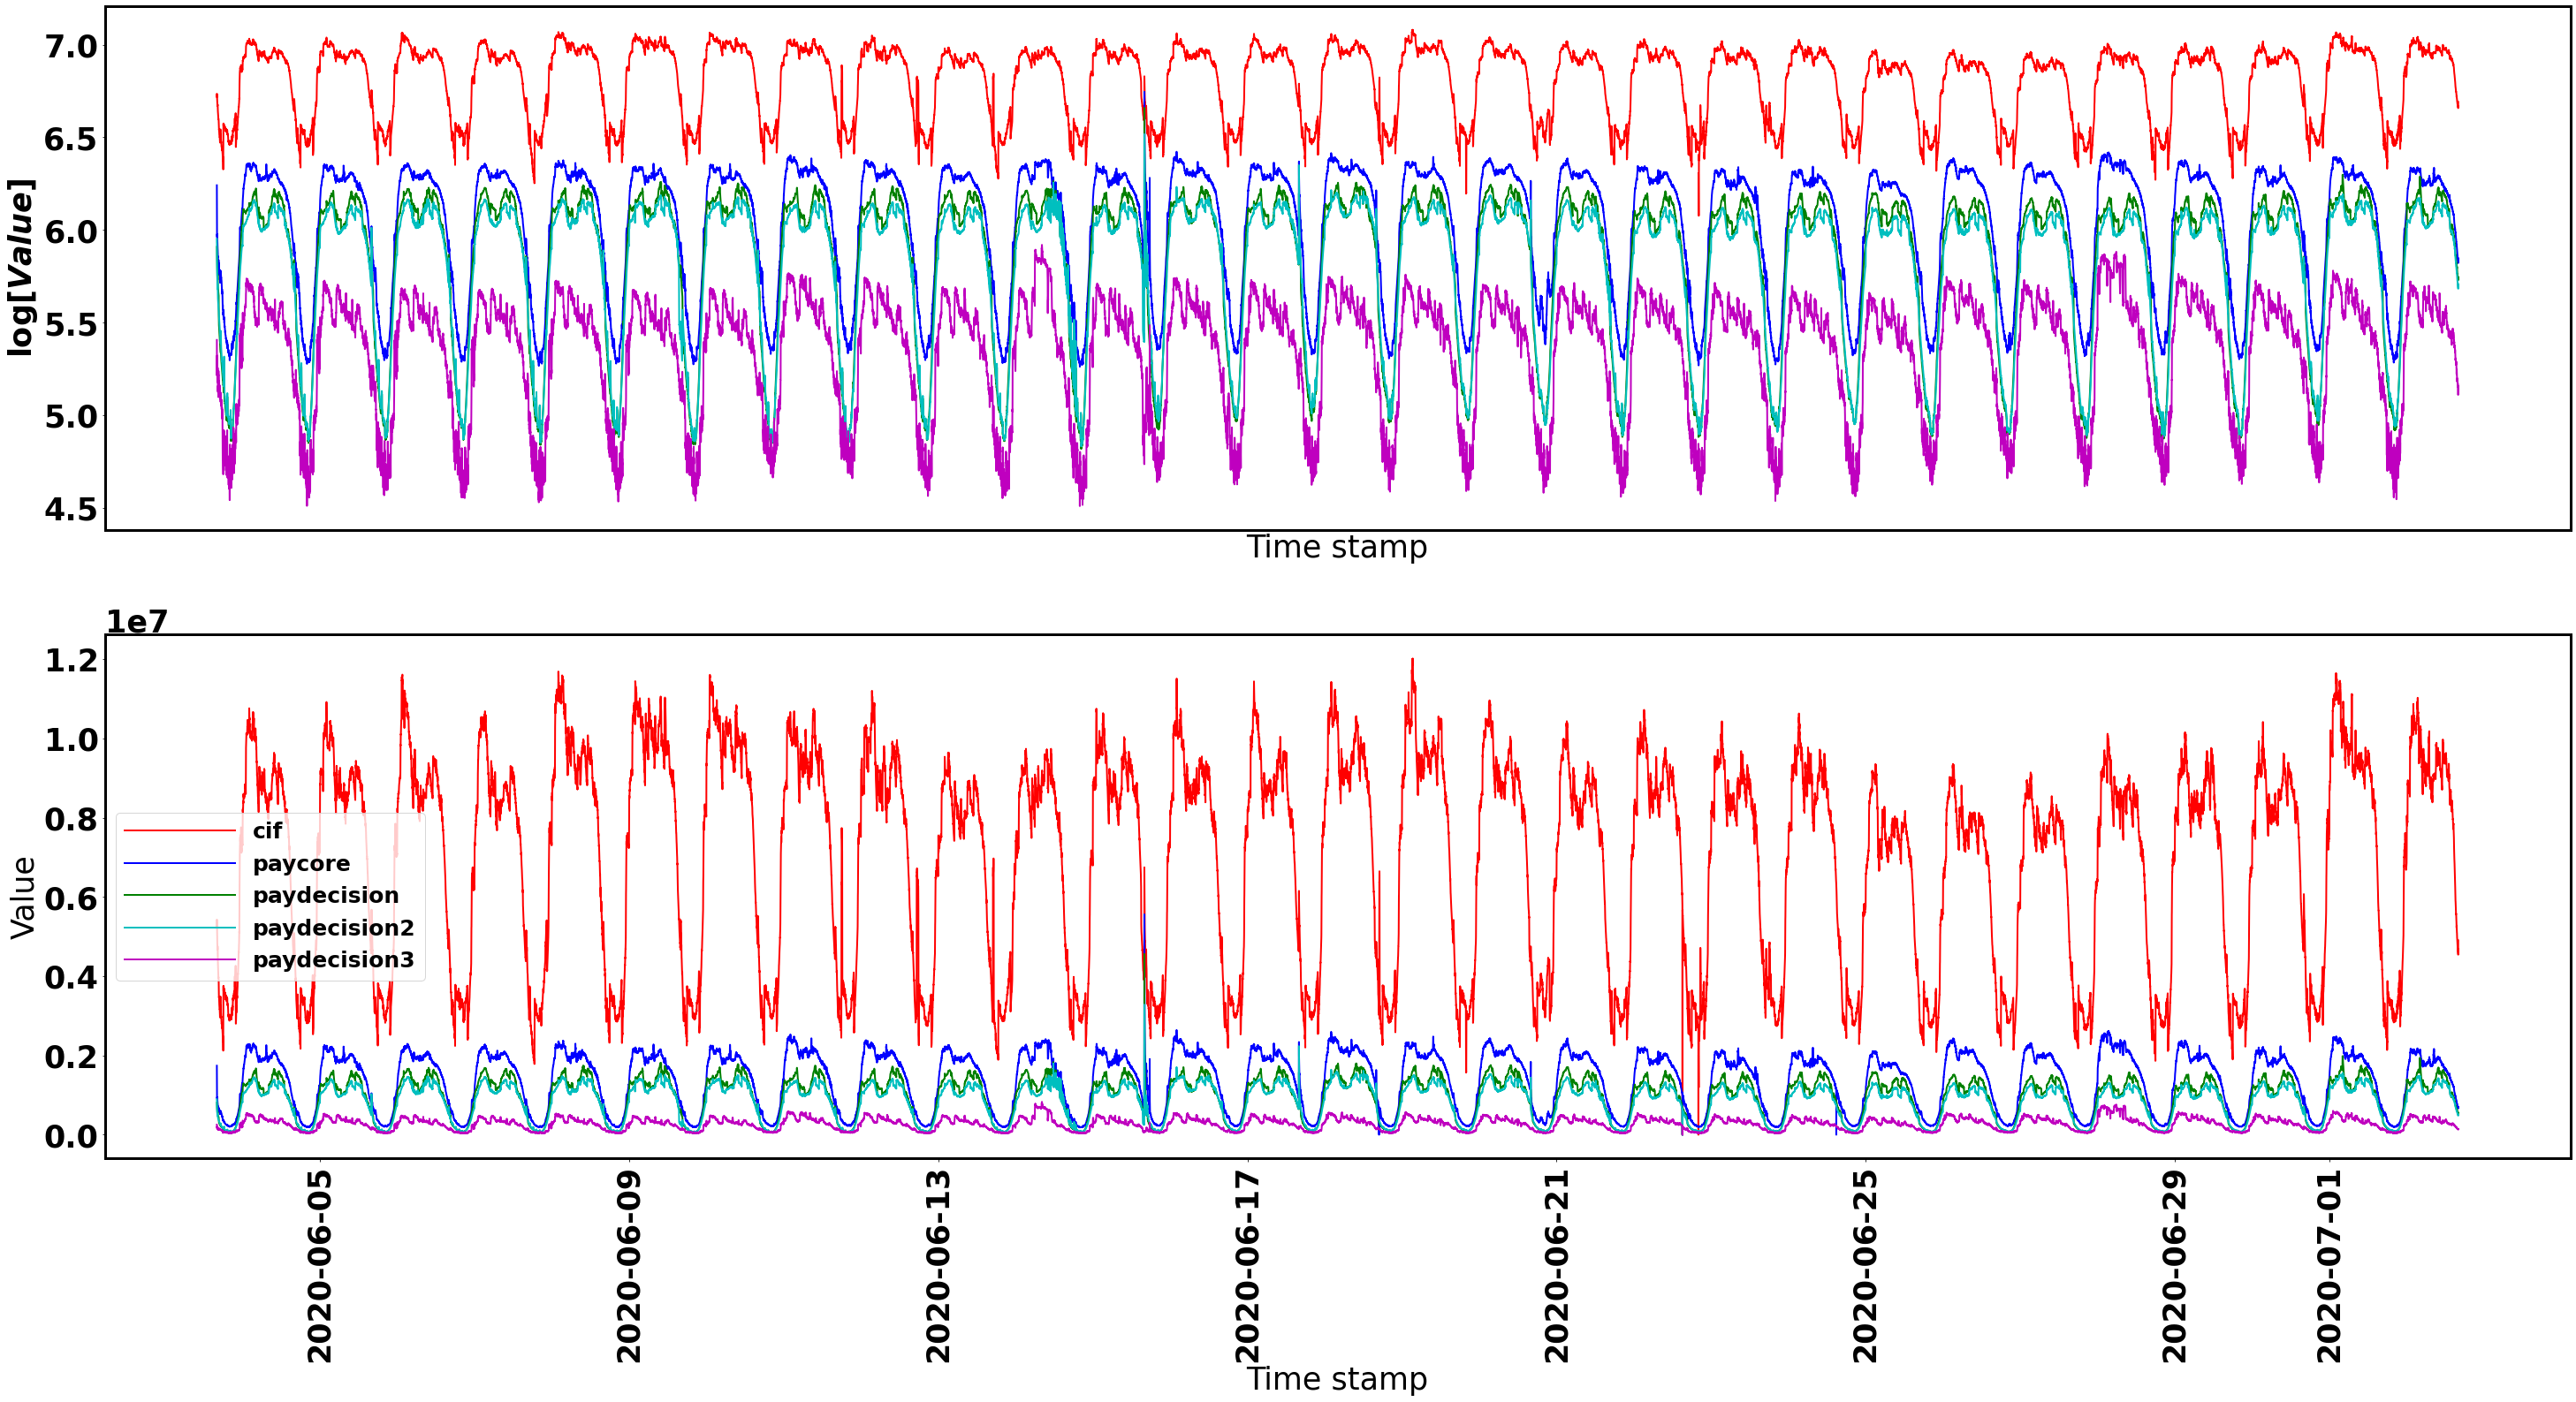

In [77]:
# A rough visualization of the data
import warnings
warnings.filterwarnings('ignore')


color_array = ['r', 'b', 'g', 'c', 'm', 'y', 'k']

from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 35}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


plt.subplot(2,1,1)


for i in range(len(names_array)):
    plt.plot(df['time_stamp'],np.log10(df[names_array[i]]),color_array[i],label=names_array[i],linewidth=2,markersize=5)
    



plt.xlabel("Time stamp")
plt.ylabel(r"$\log[Value]$")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.subplot(2,1,2)


for i in range(len(names_array)):
    plt.plot(df['time_stamp'],df[names_array[i]],color_array[i],label=names_array[i],linewidth=2,markersize=5)
    


plt.xticks(rotation=90)


plt.xlabel("Time stamp")
plt.ylabel(r"Value")


fig = matplotlib.pyplot.gcf()


fig.set_size_inches(50,24)
plt.legend(fontsize=25,handlelength=5)

save_path = plot_path + "Data_server_original" + ".png"

fig.savefig(save_path, dpi=300)



# group by hours
There is a trend in hours, which proves it's a time series problem.

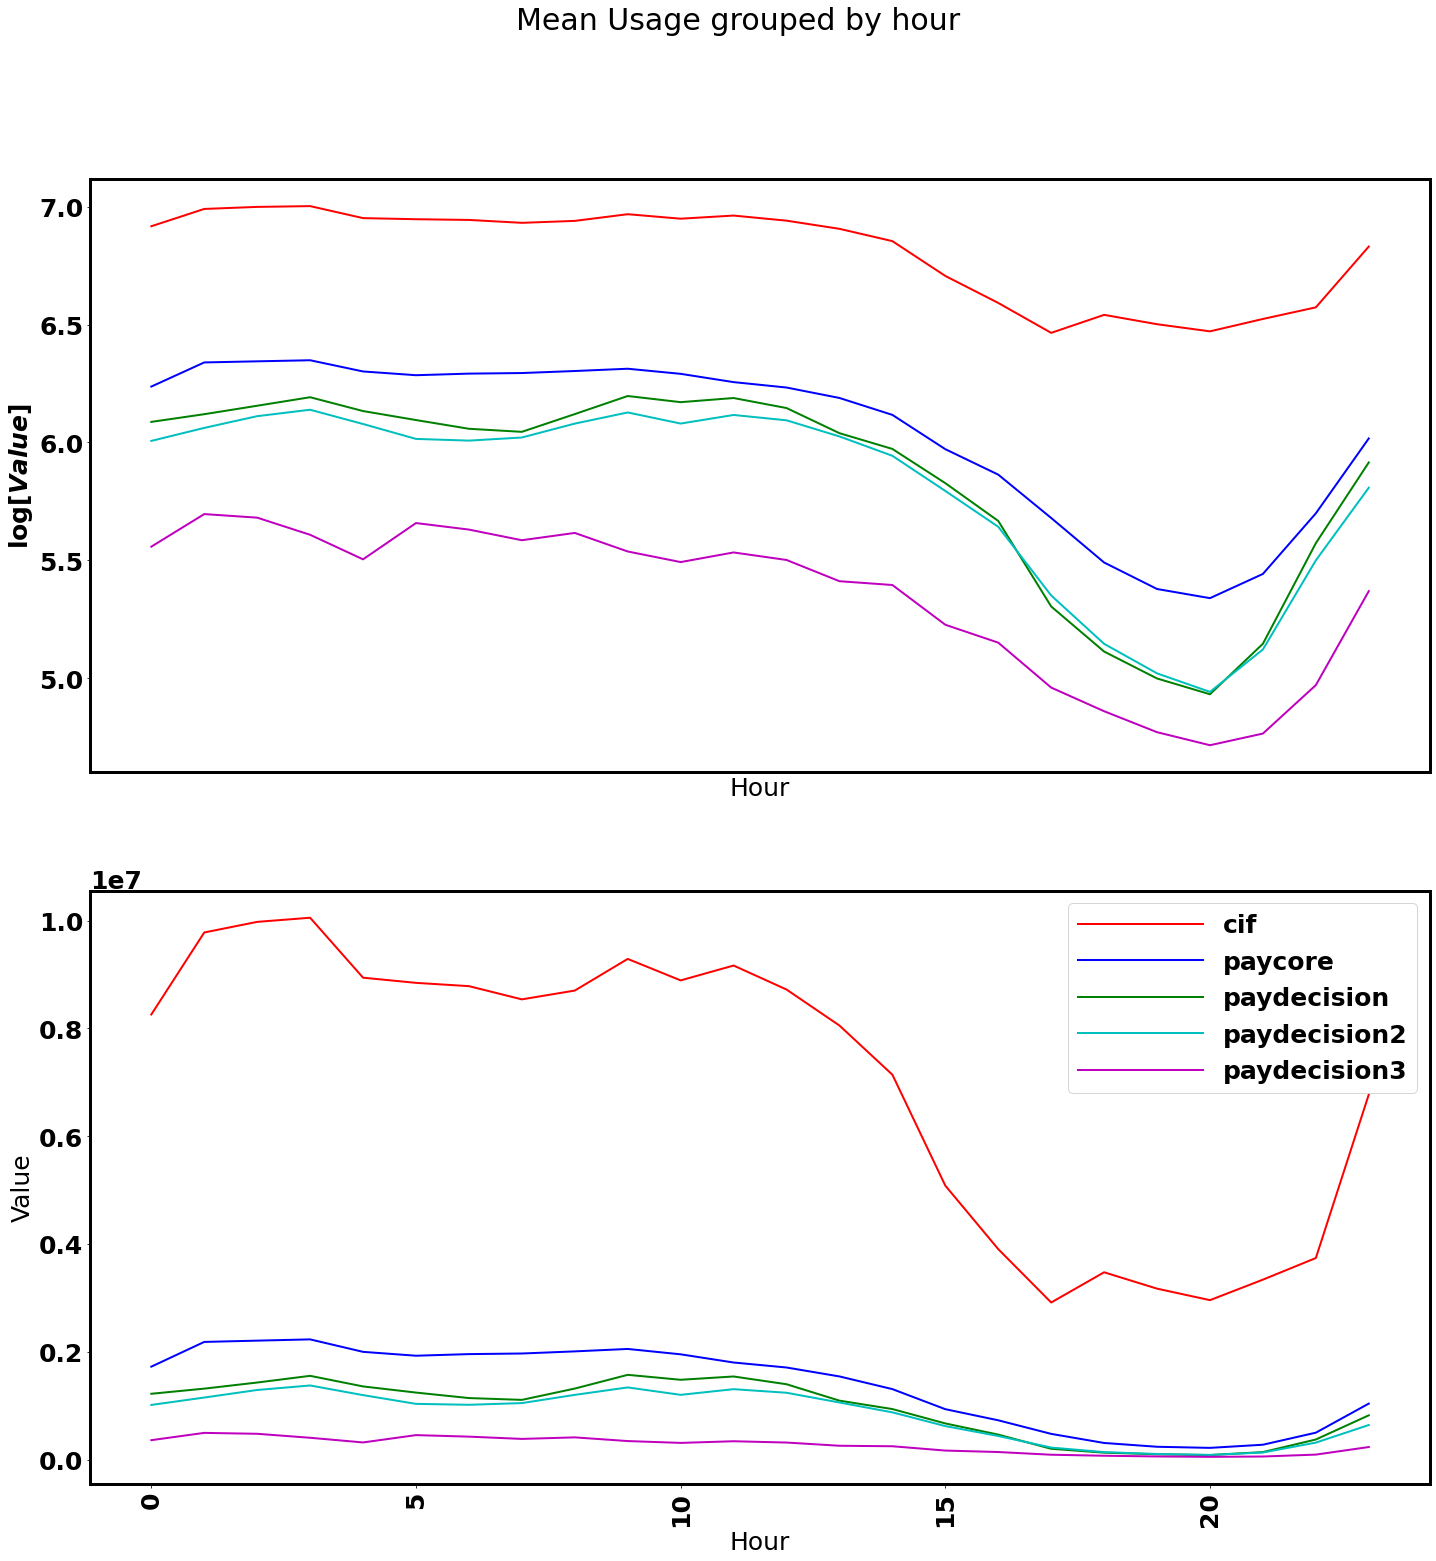

In [64]:
## group by hours
# A rough visualization of the data
import warnings
warnings.filterwarnings('ignore')


df['hours'] = df['time_stamp'].dt.hour

color_array = ['r', 'b', 'g', 'c', 'm', 'y', 'k']

from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


plt.subplot(2,1,1)



for i in range(len(names_array)):
    plt.plot(df.groupby('hours').mean().index,np.log10(df.groupby('hours').mean()[names_array[i]]),color_array[i],label=names_array[i],linewidth=2,markersize=5)
    




plt.xlabel("Hour")
plt.ylabel(r"$\log[Value]$")
plt.suptitle("Mean Usage grouped by hour")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.subplot(2,1,2)


for i in range(len(names_array)):
    plt.plot(df.groupby('hours').mean().index,df.groupby('hours').mean()[names_array[i]],color_array[i],label=names_array[i],linewidth=2,markersize=5)
    


plt.xticks(rotation=90)


plt.xlabel("Hour")
plt.ylabel(r"Value")
plt.suptitle("Mean Usage grouped by hour")


fig = matplotlib.pyplot.gcf()


fig.set_size_inches(24,24)
plt.legend(fontsize=25,handlelength=5)
save_path = plot_path + "Data_server_original_group_by_hour" + ".png"

fig.savefig(save_path, dpi=300)




# Group by day of week:
There seems to be no trend here:

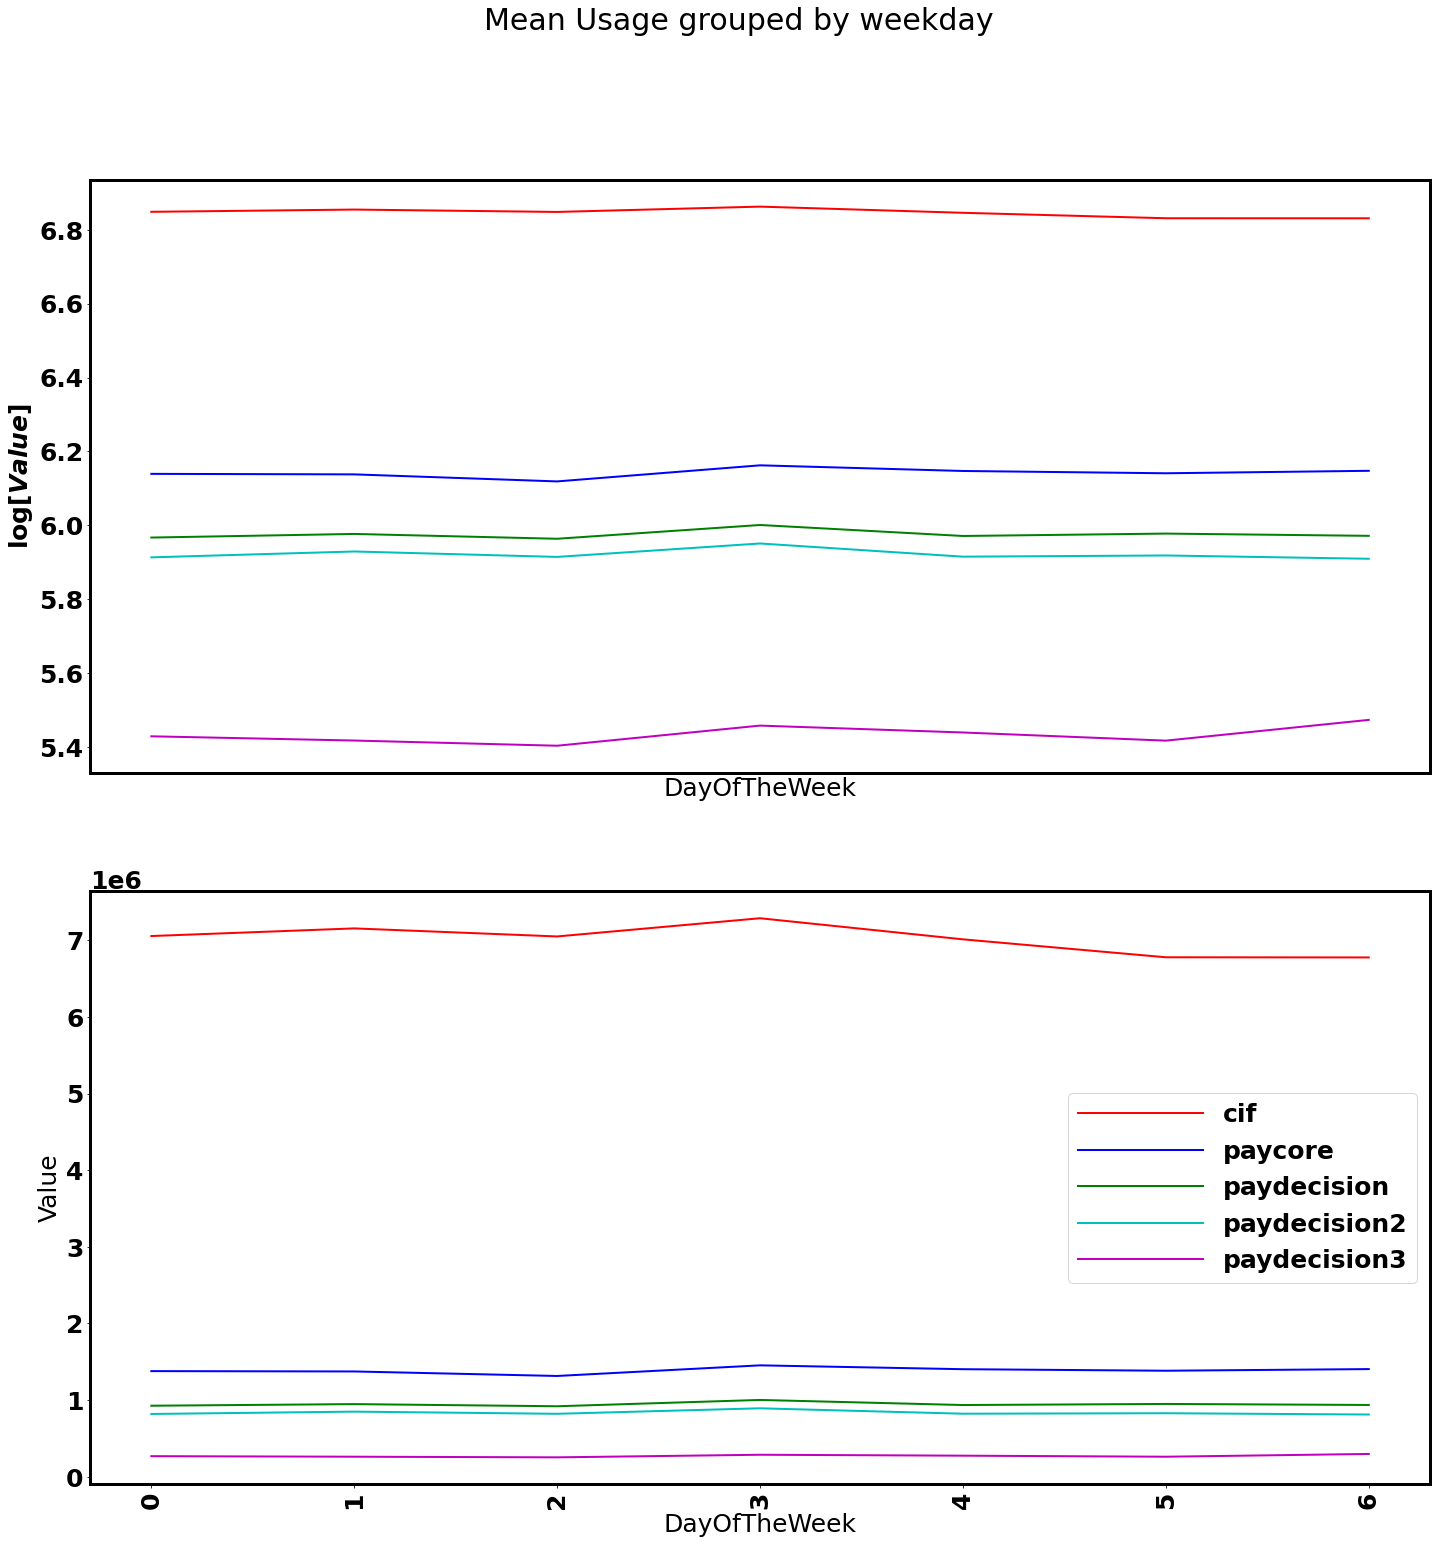

In [75]:
# Group by day of week:


## group by hours
# A rough visualization of the data
import warnings
warnings.filterwarnings('ignore')

df['DayOfTheWeek'] = df['time_stamp'].dt.dayofweek

color_array = ['r', 'b', 'g', 'c', 'm', 'y', 'k']

from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


plt.subplot(2,1,1)



for i in range(len(names_array)):
    plt.plot(df.groupby('DayOfTheWeek').mean().index,np.log10(df.groupby('DayOfTheWeek').mean()[names_array[i]]),color_array[i],label=names_array[i],linewidth=2,markersize=5)
    




plt.xlabel('DayOfTheWeek')
plt.ylabel(r"$\log[Value]$")
plt.suptitle("Mean Usage grouped by weekday")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.subplot(2,1,2)


for i in range(len(names_array)):
    plt.plot(df.groupby('DayOfTheWeek').mean().index,df.groupby('DayOfTheWeek').mean()[names_array[i]],color_array[i],label=names_array[i],linewidth=2,markersize=5)
    


plt.xticks(rotation=90)


plt.xlabel('DayOfTheWeek')
plt.ylabel(r"Value")
plt.suptitle("Mean Usage grouped by weekday")


fig = matplotlib.pyplot.gcf()


fig.set_size_inches(24,24)
plt.legend(fontsize=25,handlelength=5)
save_path = plot_path + "Data_server_original_group_by_weekday" + ".png"

fig.savefig(save_path, dpi=300)





# Baseline:
Isolation Forest. Performance not good.

cif 0    40508
1     1253
Name: anomaly_iforest_cif, dtype: int64
paycore 0    40508
1     1253
Name: anomaly_iforest_paycore, dtype: int64
paydecision 0    40540
1     1221
Name: anomaly_iforest_paydecision, dtype: int64
paydecision2 0    40508
1     1253
Name: anomaly_iforest_paydecision2, dtype: int64
paydecision3 0    40513
1     1248
Name: anomaly_iforest_paydecision3, dtype: int64


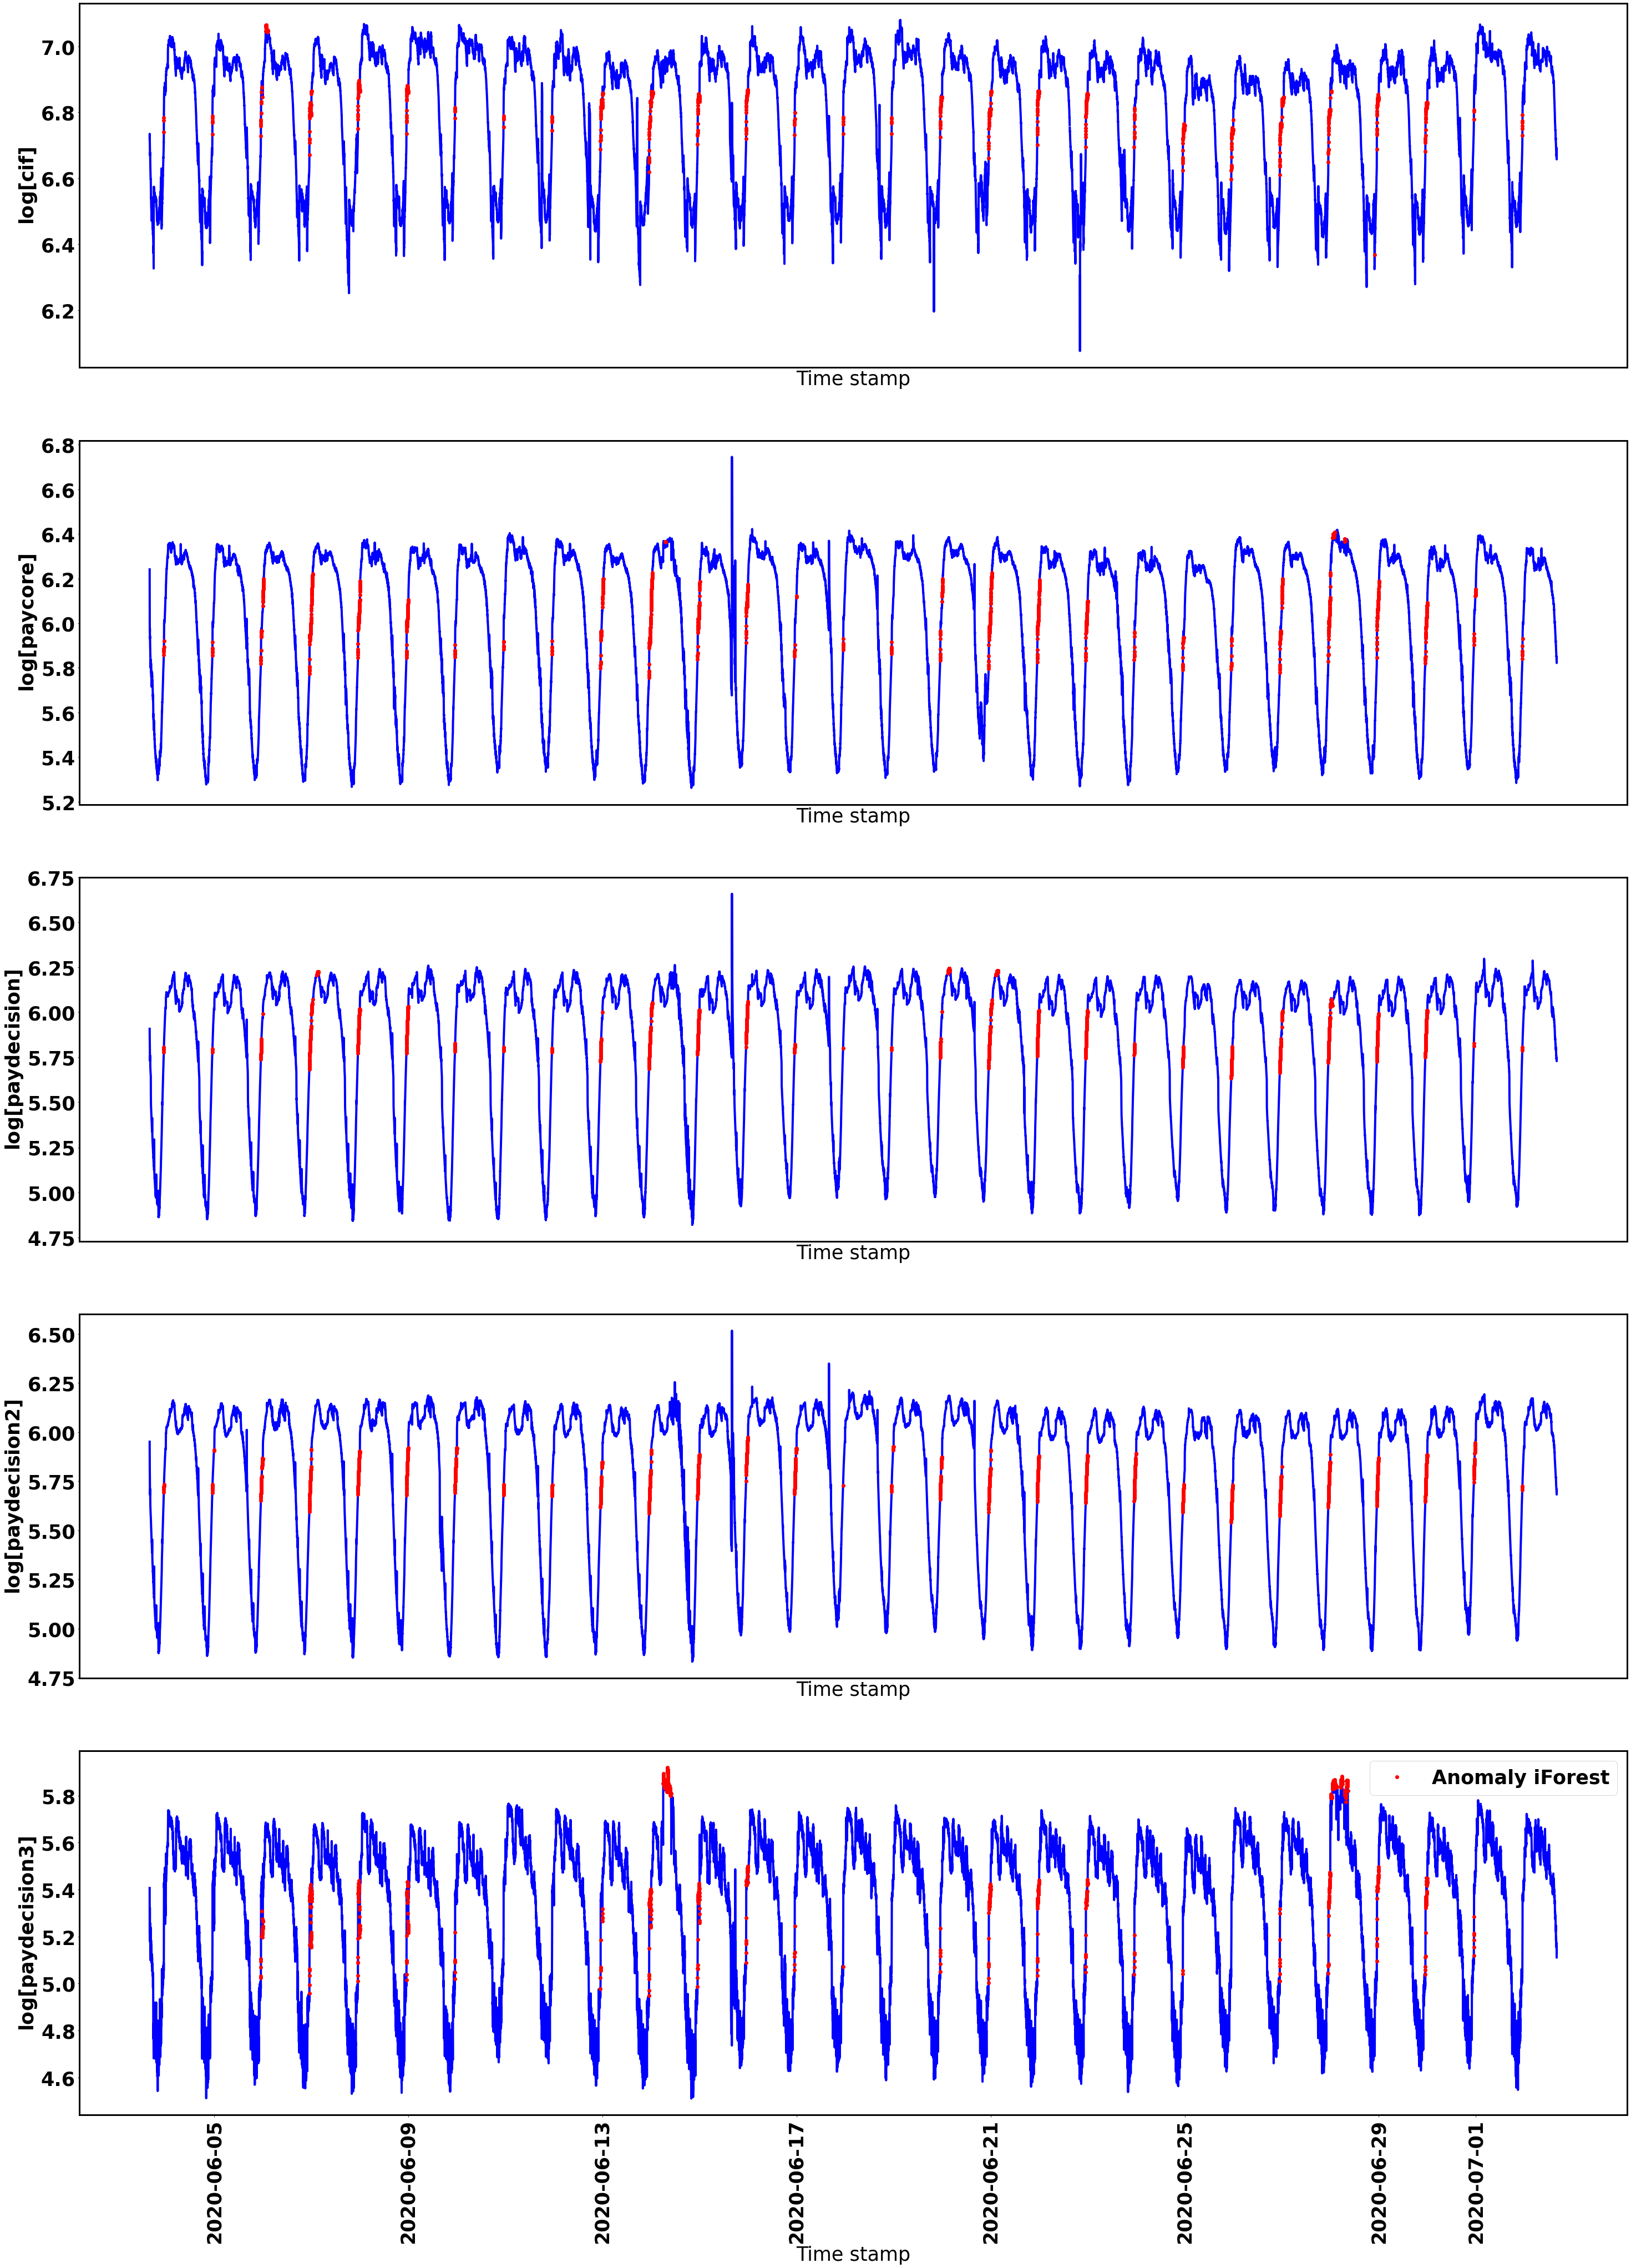

In [102]:
import gc


def log10(x):
    if x > 0:
        return math.log10(x)
    else:
        return -np.inf

    
## Some hyper-parameters:
outliers_fraction=0.03

# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)
df['DayOfTheWeek'] = df['time_stamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)



font = {'family': 'normal','weight': 'bold',
        'size': 35}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)



for i in range(len(names_array)):
    plt.subplot(len(names_array),1,i+1)
    
    data = df[[names_array[i], 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
    # try use log?
    if False:
        temp = np.log10(data[names_array[i]])
        mask_inf = np.isinf(temp)
        temp[mask_inf]=-9999
        data[names_array[i]] = temp
    
    min_max_scaler = preprocessing.StandardScaler()

    # min-max scaler
    np_scaled = min_max_scaler.fit_transform(data)

    data = pd.DataFrame(np_scaled)

    # train Iforest 
    model =  IsolationForest(contamination = outliers_fraction)
    model.fit(data)
    # add the data to the main  
    df['anomaly_iforest_'+names_array[i]] = pd.Series(model.predict(data))
    df['anomaly_iforest_'+names_array[i]] = df['anomaly_iforest_'+names_array[i]].map( {1: 0, -1: 1} )
    print(names_array[i],df['anomaly_iforest_'+names_array[i]].value_counts())


    mask = df['anomaly_iforest_'+names_array[i]]==1

    plt.plot(df['time_stamp'],np.log10(df[names_array[i]]),"b",linewidth=4)

    plt.plot(df[mask]['time_stamp'],np.log10(df[mask][names_array[i]]),"ro",linewidth=4,label="Anomaly iForest")

    plt.xlabel("Time stamp")
    plt.ylabel(r"$\log [\rm %s]$"%names_array[i])

    if i<len(names_array)-1:
        plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    else:
        plt.xticks(rotation=90)
        
    gc.collect()


fig = matplotlib.pyplot.gcf()




fig.set_size_inches(50,14*5)
plt.legend()


save_path = plot_path + "Data_server_iForest" + ".png"

fig.savefig(save_path, dpi=300)

